In [130]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.pipeline import Pipeline, FeatureUnion
from scipy.stats import yeojohnson
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap

In [131]:
parts_data = pd.read_csv('/Users/skylerwilson/Desktop/Lighthouse_Labs/Projects/final_project/data/Project_Data/final_parts_data.csv')

In [132]:
# Clean sales data function
def clean_sales_data(df, column_names):
    for col in column_names:  
        df[col] = np.abs(df[col])
    return df

# Clean quantity data function
def clean_quantity_data(df, quantity_col):
    return df[df[quantity_col] > 0]

# Clean turnover data function
def clean_negative_data(df, turnover_col):
    return df[df[turnover_col] >= 0]


def z_score(column, threshold=2):
    z_scores = (column - column.mean()) / column.std()
    return np.abs(z_scores) < threshold

sales_data = ['Sales Last Month', 'Sales Last 3 Months', 'Sales Last 6 Months', 'Sales Last 9 Months',
              'Sales Last 12 Months', 'Sales Last 2 Years', 'Sales Last 3 Years',
              'Sales Last 4 Years', 'Sales Last 5 Years', 'Sales Last 10 Years',
              'Months No Sale', 'Reorder Point', 'Sales - Jan', 'Sales - Feb',
              'Sales - Mar', 'Sales - Apr', 'Sales - May', 'Sales - Jun',
              'Sales - Jul', 'Sales - Aug', 'Sales - Sep', 'Sales - Oct',
              'Sales - Nov', 'Sales - Dec', 'Sales - 1st Qtr', 'Sales - 2nd Qtr',
              'Sales - 3rd Qtr', 'Sales - 4th Qtr', 'Sales - This Year','Sales - Last Year']
quantity_col = 'Quantity'
turnover_col = 'Turnover'

num_cols = parts_data.select_dtypes(include='number').columns

# Apply preprocessing steps
parts_data = clean_sales_data(parts_data, sales_data)
parts_data = clean_quantity_data(parts_data, quantity_col)
parts_data = clean_negative_data(parts_data, turnover_col)


# Apply z-score transformation to numerical columns
parts_data[num_cols] = parts_data[parts_data[num_cols].apply(z_score)][num_cols]

#deals with columns that dont have data yet so they end up as NaN when they shouldnt
parts_data[num_cols] = np.where(parts_data[num_cols].isna(), 0, parts_data[num_cols])

In [133]:
# Custom transformer classes
class YeoJohnsonTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        transformed_data = X.copy()
        for col in self.columns:
            transformed_data[col], _ = yeojohnson(X[col] + 0.01)  # Adding 0.01 to avoid zero values
        return transformed_data

# Load and preprocess the data
X = parts_data.select_dtypes(include='number')
constant_columns = X.columns[X.nunique() == 1]
X.drop(columns=constant_columns, inplace=True)

X_train, X_test= train_test_split(X, test_size=0.2, random_state=42, shuffle=True)

# Define columns to transform
cols_to_transform = X.columns

# Column transformer for Yeo-Johnson transformation
yeo_johnson_cols = ColumnTransformer(
    transformers=[('yeo_johnson', YeoJohnsonTransformer(columns=cols_to_transform), cols_to_transform)],
    remainder='passthrough'
)

# Create FeatureUnion combining TruncatedSVD and SelectKBest
features = FeatureUnion([
    ('svd', TruncatedSVD(n_components=10))
])

final_pipeline = Pipeline([
    ('transformer', yeo_johnson_cols),
    ('features', features),
    ('scaler', RobustScaler()),
])

final_pipeline.fit(X_train)

X_train_transformed = final_pipeline.named_steps['transformer'].transform(X_train)
X_train_transformed = final_pipeline.named_steps['features'].transform(X_train_transformed)
X_train_transformed = final_pipeline.named_steps['scaler'].transform(X_train_transformed)

# Transform the testing data using the pipeline
X_test_transformed = final_pipeline.named_steps['transformer'].transform(X_test)
X_test_transformed = final_pipeline.named_steps['features'].transform(X_test_transformed)
X_test_transformed = final_pipeline.named_steps['scaler'].transform(X_test_transformed)

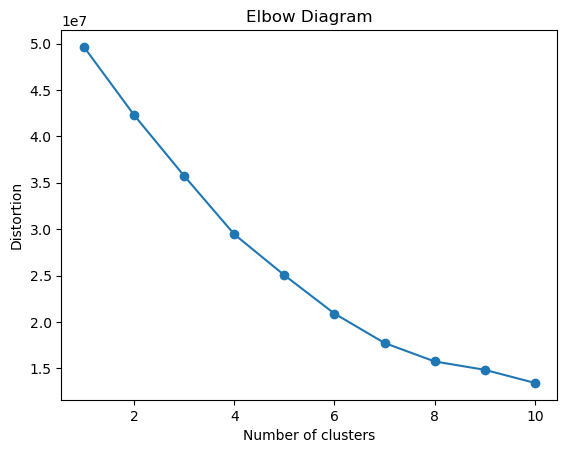

In [134]:
def plot_distortion(pipeline, max_clusters=10):
    X_transformed = pipeline.named_steps['transformer'].transform(X_train)
    X_transformed = pipeline.named_steps['features'].transform(X_transformed)
    X_transformed = pipeline.named_steps['scaler'].transform(X_transformed)
    
    distortions = []
    for k in range(1, max_clusters + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
        km.fit(X_transformed)
        distortions.append(km.inertia_)

    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Diagram')
    plt.show()

# Call the function with your pipeline
plot_distortion(final_pipeline)

In [135]:
silhouette_scores = []
X_transformed = final_pipeline.named_steps['transformer'].transform(X_train)
X_transformed = final_pipeline.named_steps['features'].transform(X_transformed)
X_transformed = final_pipeline.named_steps['scaler'].transform(X_transformed)

for k in range(3, 10):
    km = KMeans(n_clusters=k, init='k-means++', n_init=15, random_state=42)
    kmeans_labels = km.fit_predict(X_transformed)
    silhouette_scores.append(silhouette_score(X_transformed, kmeans_labels))

# Find the index of the K with the highest silhouette score
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 3  # Add 4 because we started from K=4
print("Optimal number of clusters from Silhouette Score:", optimal_k)

Optimal number of clusters from Silhouette Score: 4


In [136]:
svd = final_pipeline.named_steps['features'].transformer_list[0][1]
# Normalize singular values to use as weights
normalized_singular_values = normalize([svd.singular_values_], norm='l1')

# Multiply the transformed data by normalized singular values to get weighted transformed data
weighted_transformed_data = X_train_transformed * normalized_singular_values

In [226]:
# Access the SVD transformer within the FeatureUnion
svd_transformer = final_pipeline.named_steps['features'].transformer_list[0][1]

# Normalize singular values to use as weights
normalized_singular_values = normalize([svd_transformer.components_[0]], norm='l1')
criteria_weights = normalized_singular_values.squeeze()

# Perform KMeans clustering on the transformed data
n_clusters = 4
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
cluster_assignments = kmeans_model.fit_predict(X_train_transformed)

n_samples, n_features = X_train_transformed.shape

# Create a DataFrame with the clustering results
cluster_data = pd.DataFrame({'ItemID': np.arange(1, n_samples + 1), 'Cluster': cluster_assignments})

# Calculate criteria scores using dot product with weights
criteria_scores = np.dot(X_train_transformed, criteria_weights[:n_features])
cluster_data['Score'] = criteria_scores

# Sort items within each cluster based on scores
sorted_cluster_data = cluster_data.sort_values(by=['Cluster', 'Score'], ascending=[True, False])

# Calculate thresholds for A, B, and C categories within each cluster
a_threshold = int(n_samples * 0.55)
b_threshold = int(n_samples * 0.85)

# Assign categories based on thresholds
sorted_cluster_data['Category'] = 'Obsolete'
sorted_cluster_data.loc[sorted_cluster_data.groupby('Cluster').head(a_threshold).index, 'Category'] = 'Essential'
sorted_cluster_data.loc[sorted_cluster_data.groupby('Cluster').tail(b_threshold - a_threshold).index, 'Category'] = 'Non-Essential'

sorted_cluster_data

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,ItemID,Cluster,Score,Category
291,292,0,2.375030,Essential
4377,4378,0,2.366012,Essential
7675,7676,0,2.306391,Essential
2395,2396,0,2.304065,Essential
5453,5454,0,2.294187,Essential
...,...,...,...,...
7177,7178,3,-1.852947,Non-Essential
7616,7617,3,-2.024667,Non-Essential
3144,3145,3,-4.719058,Non-Essential
988,989,3,-9.739817,Non-Essential


In [227]:
(sorted_cluster_data['Category'].value_counts() / len(sorted_cluster_data['Category'])) * 100

Essential        54.995197
Non-Essential    35.194524
Obsolete          9.810279
Name: Category, dtype: float64

In [225]:
import plotly.express as px

# Assuming you have sorted_cluster_data available

# Calculate mean scores for each category
mean_scores = sorted_cluster_data.groupby('Category')['Score'].mean().reset_index()

# Create an interactive bar chart using Plotly Express
fig = px.bar(mean_scores, x='Category', y='Score', title='Mean Score for Each Category')
fig.show()

